# Subset PVN 



## General points
- All processing of the data is done primarily in functions to avoid overusing global variables

In [1]:
import os
import pickle
os.chdir("../../")

import pymde
import numpy as np
import pandas as pd
pymde.seed(0)

import scanpy as sc
import scvi

from Functions import integrate_datasets, plot_loss, process_integration, mde_embedding

Global seed set to 0


<Figure size 72x72 with 0 Axes>

## Load integrated data

In [2]:
adata = sc.read("Output/Data/2-Integration/1-Merged.h5ad")

with open(f"Output/Data/2-Integration/1-VAE.p", "rb") as f:
  _, scanvae = pickle.load(f)

In [3]:
process_integration(adata, scanvae)
mde_embedding(adata)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


## Subsetting

- A subset of the PVN is taken using Xu *et al*. (2020) as benchmark.
- First, the subset is taken at the SCANVI predicted C66 annotation level
  - Clusters containing >= 5 cells from Xu2020 are included


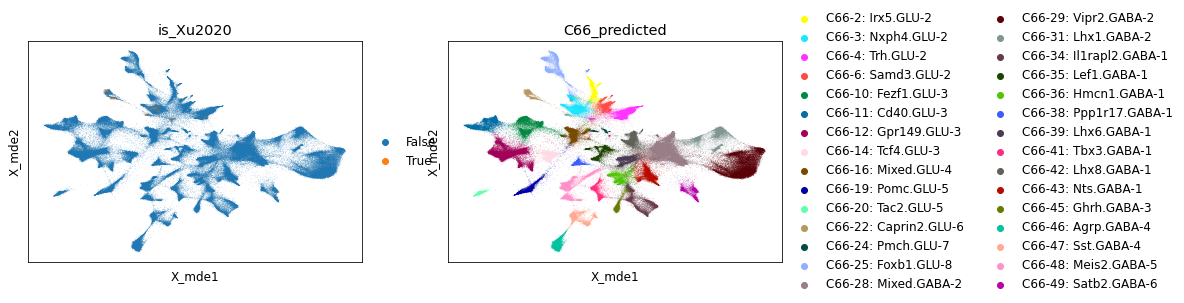

In [4]:
adata.obs["is_Xu2020"] = np.array(adata.obs.Dataset == "Xu2020", dtype = str)
sc.pl.embedding(adata, "X_mde", color = ["is_Xu2020", "C66_predicted"])

In [5]:
pd.crosstab(adata.obs.C66_predicted, adata.obs.is_Xu2020).sort_values(by = "True", ascending = False).head(8).T

C66_predicted,C66-22: Caprin2.GLU-6,C66-3: Nxph4.GLU-2,C66-4: Trh.GLU-2,C66-49: Satb2.GABA-6,C66-24: Pmch.GLU-7,C66-6: Samd3.GLU-2,C66-2: Irx5.GLU-2,C66-28: Mixed.GABA-2
is_Xu2020,,,,,,,,
False,2560,8588,8173,4227,1651,5176,5129,23018
True,387,173,94,19,10,8,5,3


In [6]:
def subset_pvn(adata: sc.AnnData) -> None:
    before = np.sum(adata.obs.is_Xu2020 == "True")

    subset = [
        "C66-22: Caprin2.GLU-6", 
        "C66-3: Nxph4.GLU-2", 
        "C66-4: Trh.GLU-2", 
        "C66-49: Satb2.GABA-6",
        "C66-24: Pmch.GLU-7", 
        "C66-6: Samd3.GLU-2",
        "C66-2: Irx5.GLU-2",
    ]
    subset = [x in subset for x in adata.obs.C66_predicted]
    adata._inplace_subset_obs(subset)
    
    after = np.sum(adata.obs.is_Xu2020 == "True")
    print(f"After: {after}, Before: {before}. Retained {after/before*100:.2f}% of Xu2020 cells.")

subset_pvn(adata)

After: 696, Before: 706. Retained 98.58% of Xu2020 cells.


- Secondly, the subset is clustered using the leiden algorithm
  - Clusters containing >= 5 cells from Xu2020 are included

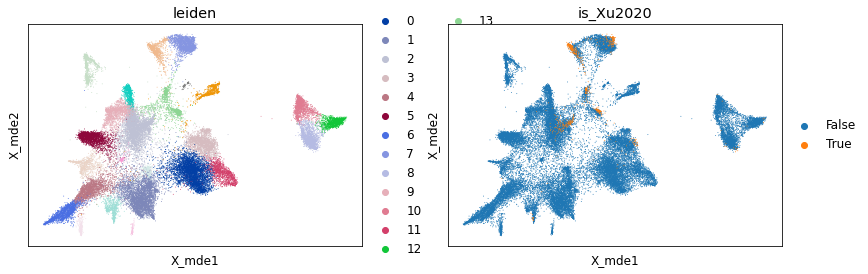

In [7]:
def leiden_clustering(adata: sc.AnnData, resolution = 1) -> None:
    leiden = adata.copy()
    sc.pp.normalize_total(leiden)
    sc.pp.log1p(leiden)
    sc.pp.neighbors(leiden, n_neighbors = 30, use_rep = "X_vae")
    sc.tl.leiden(leiden, resolution = resolution)
    adata.obs["leiden"] = leiden.obs["leiden"]

leiden_clustering(adata, resolution = 1)
mde_embedding(adata)
sc.pl.embedding(adata, "X_mde", color = ["leiden", "is_Xu2020"])

In [8]:
pd.crosstab(adata.obs.leiden, adata.obs.is_Xu2020).sort_values(by = "True", ascending = False).head(10).T

leiden,16,2,13,7,3,8,19,0,12,9
is_Xu2020,,,,,,,,,,
False,624,3797,989,1690,2039,1613,641,4379,1189,1480
True,224,140,139,114,35,12,10,5,4,3


In [9]:
def subset_pvn(adata: sc.AnnData) -> None:
    before = np.sum(adata.obs.is_Xu2020 == "True")
    
    subset = [str(x) for x in [16,2,13,7,3,8,19,0]]
    subset = [x in subset for x in adata.obs.leiden]
    adata._inplace_subset_obs(subset)

    after = np.sum(adata.obs.is_Xu2020 == "True")
    print(f"After: {after}, Before: {before}. Retained {after/before*100:.2f}% of Xu2020 cells.")

subset_pvn(adata)

After: 679, Before: 696. Retained 97.56% of Xu2020 cells.


- Finally, the subset is integrated again and stored for annotation

In [10]:
scvi.settings.seed = 1
scvae, scanvae = integrate_datasets(adata, n_genes = 1000)


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [05:59<00:00,  1.11it/s, loss=542, v_num=1]
INFO     Training for 250 epochs.                                                            


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 126/250:  50%|█████     | 126/250 [04:35<04:31,  2.19s/it, loss=1.16e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 539.358. Signaling Trainer to stop.


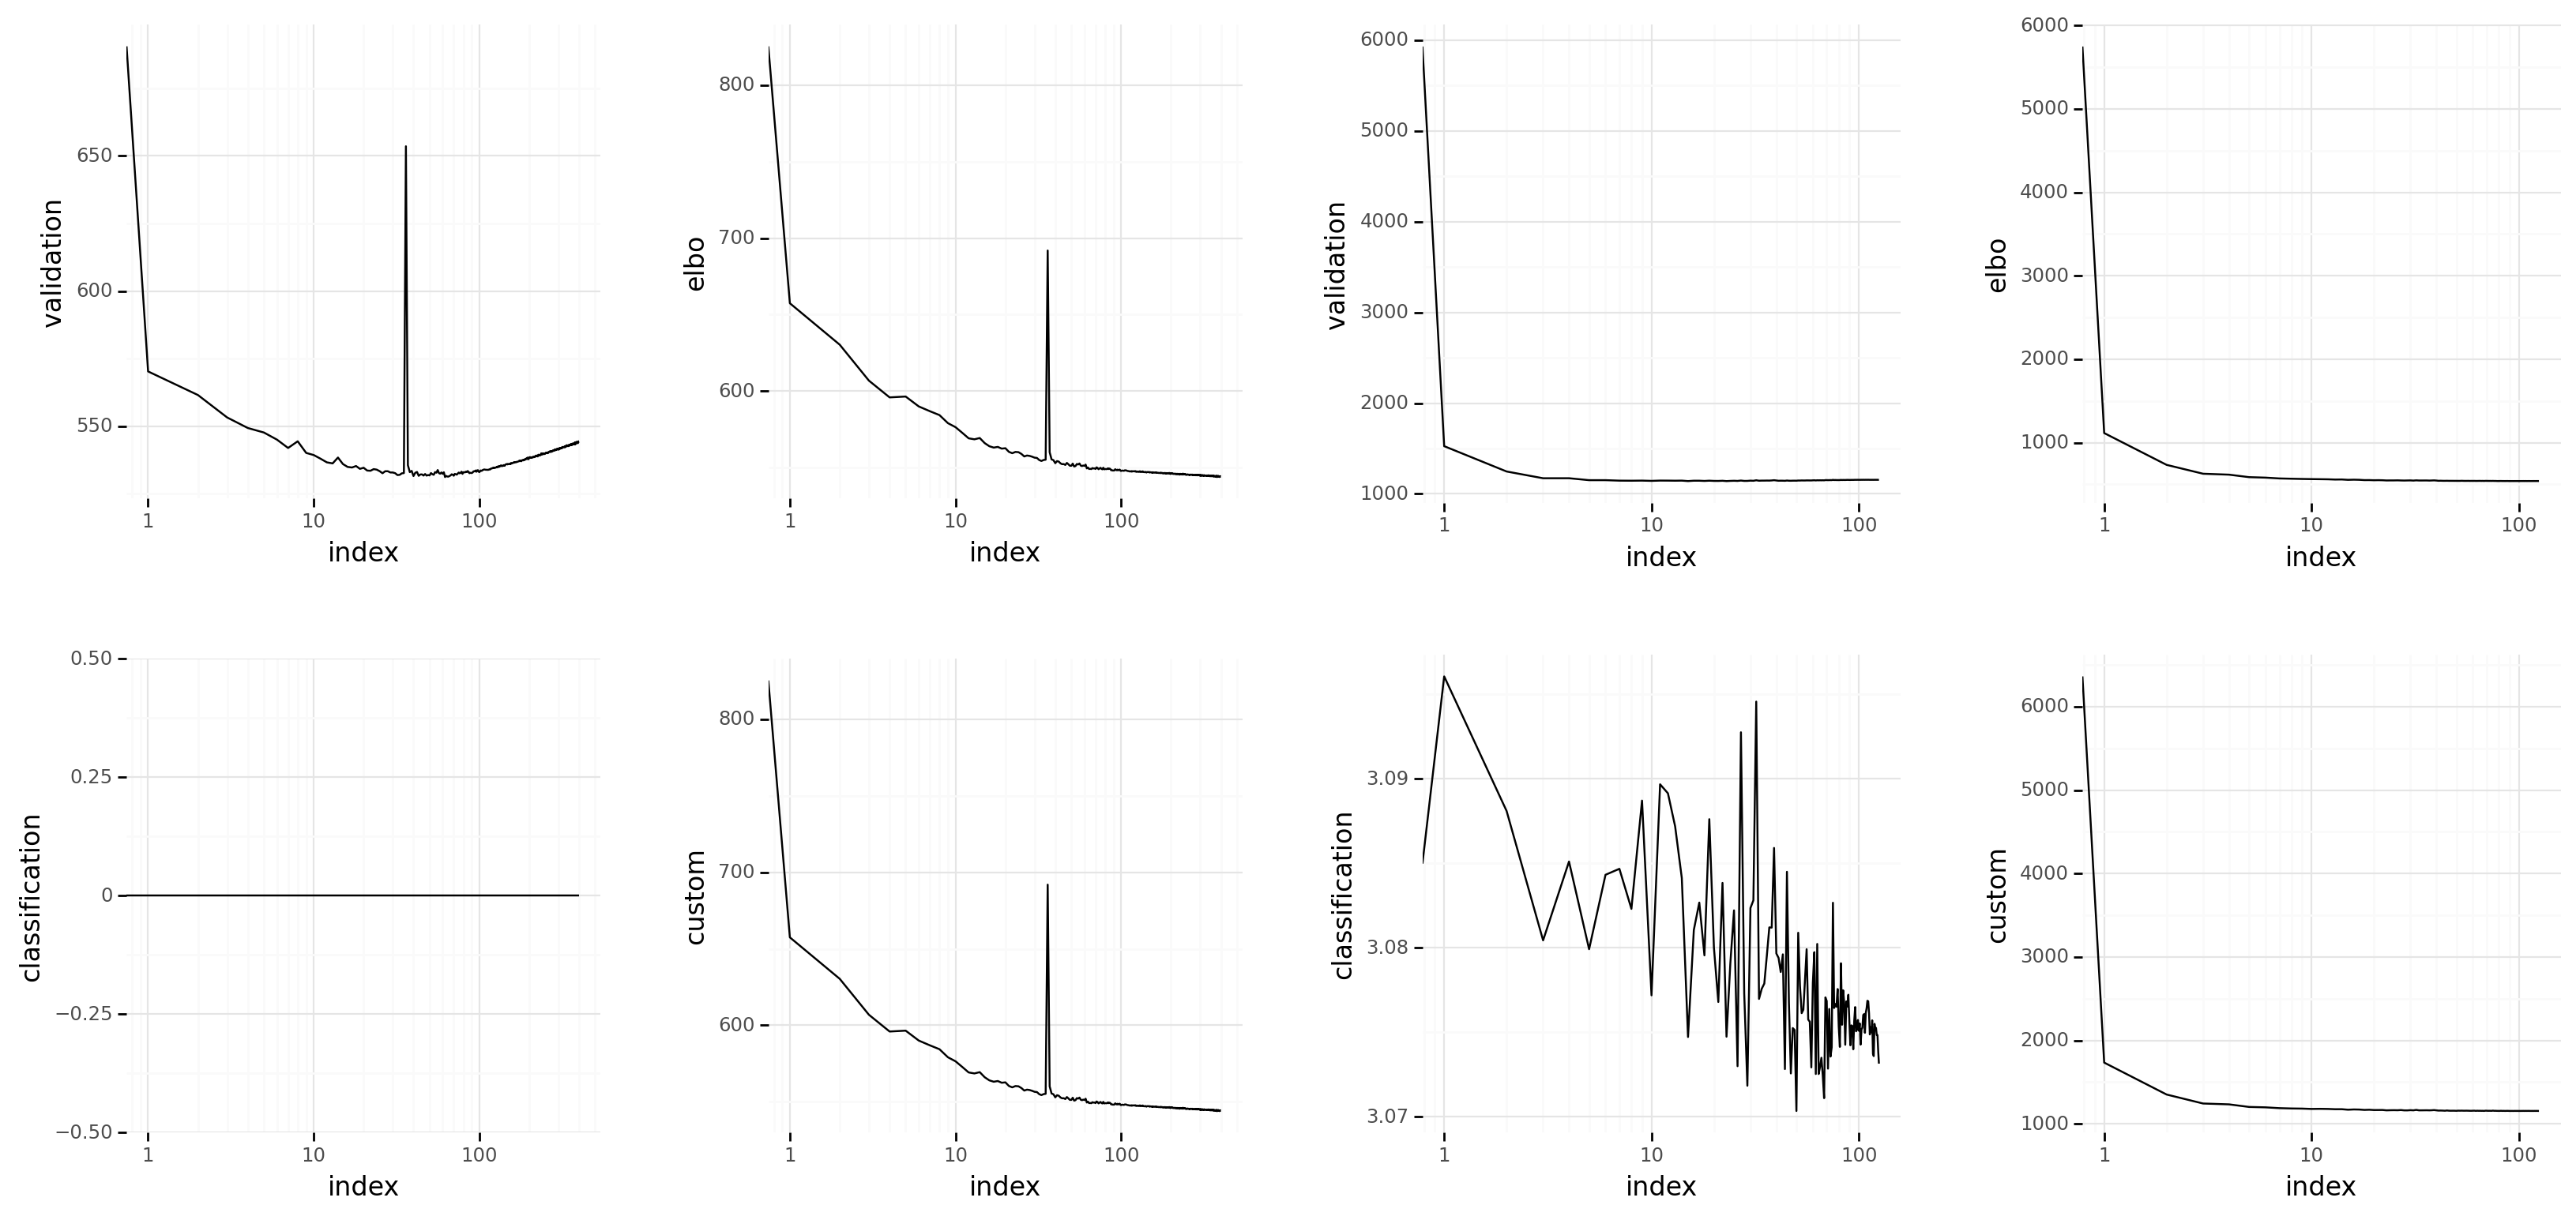

In [11]:
plot_loss(scvae) | plot_loss(scanvae)

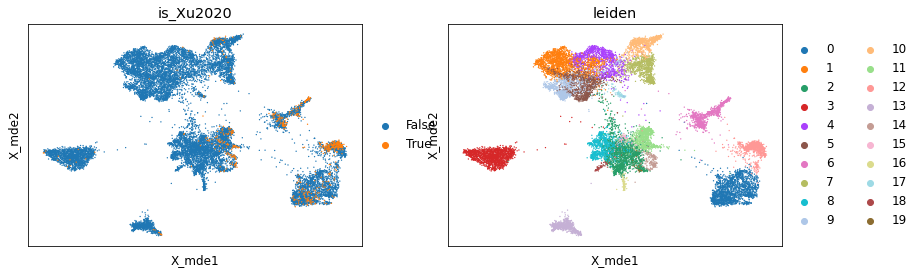

In [12]:
process_integration(adata, scanvae)
leiden_clustering(adata, resolution = 1)
mde_embedding(adata)
sc.pl.embedding(adata, "X_mde", color = ["is_Xu2020", "leiden"])

In [13]:
adata.write_h5ad("Output/Data/2-Integration/2-Subset.h5ad")